<a href="https://colab.research.google.com/github/fawadmehboob/2D-Rocket-Landing/blob/main/2D_Rocket_Landing_Attempt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl

In [ ]:
class RocketPlant:
    def __init__(self, initial_state, m=1.0, l=1.0, g=9.81, dt=0.01):
        self.state = np.array(initial_state, dtype=float)  # [x, y, theta, x_dot, y_dot, theta_dot]
        self.m = m
        self.l = l
        self.J = self.m * (self.l**2) /12
        self.g = g
        self.dt = dt

    def step(self, action):
        T, phi = action
        x, y, theta, x_dot, y_dot, theta_dot = self.state

        x_ddot = T * np.sin(theta + phi) / self.m
        y_ddot = (T * np.cos(theta + phi) / self.m )- self.g
        theta_ddot = 6 * T * np.sin(phi) / (self.m * self.l)

        x_dot_new = x_dot + x_ddot * self.dt
        y_dot_new = y_dot + y_ddot * self.dt
        theta_dot_new = theta_dot + theta_ddot * self.dt
        x_new = x + x_dot * self.dt
        y_new = y + y_dot * self.dt
        theta_new = theta + theta_dot * self.dt

        self.state = np.array([x_new, y_new, theta_new, x_dot_new, y_dot_new, theta_dot_new])
        return self.state



In [ ]:
class EnergyController:

    def __init__(self, plant, T_max=20.0, k=2.0):
        self.plant = plant
        self.T_max = T_max
        self.k = k
        self.dt = plant.dt

    def _compute_energy(self, state, m, l, g):
        x, y, theta, x_dot, y_dot, theta_dot = state

        kinetic_linear = 0.5 * m * (x_dot**2 + y_dot**2)
        kinetic_rotational = (m * l**2 * theta_dot**2) / 24
        potential = m * g * y

        E_tot = kinetic_linear + kinetic_rotational + potential
        return E_tot


    def get_action (self, state):
        x, y, theta, x_dot, y_dot, theta_dot = state
        m, l, g = self.plant.m, self.plant.l, self.plant.g

        # Total energy
        E_tot = self._compute_energy(state, m, l, g)

        # Desired thrust direction: opposite velocity
        phi = np.arctan2(y_dot, x_dot) + np.pi - theta

        # Normalize phi to [-pi, pi]
        phi = (phi + np.pi) % (2 * np.pi) - np.pi

         # Ensure that rotational term is positive: sign(theta_dot) == sign(sin(phi))
        if np.sign(theta_dot) != np.sign(np.sin(phi)) and abs(theta_dot) > 1e-3:
            phi += np.pi
            phi = (phi + np.pi) % (2 * np.pi) - np.pi

        # Compute the control effort
        velocity_term = x_dot * np.sin(theta + phi) + y_dot * np.cos(theta + phi)
        rotational_term = 0.5 * l * theta_dot * np.sin(phi)
        u = velocity_term + rotational_term

        # Thrust magnitude (ensure dot(V) < 0): if E_tot * u > 0, flip direction
        if E_tot * u > 0:
            phi += np.pi
            phi = (phi + np.pi) % (2 * np.pi) - np.pi
         # Apply safe thrust: proportional to energy, limited in magnitude
        T = self.k * abs(E_tot)
        T = np.clip(T, 0.0, self.T_max)

        return T, phi




In [ ]:

class Simulation:
    def __init__(self, plant, controller, t_final=10.0):
        self.plant = plant
        self.controller = controller
        self.t_final = t_final
        self.dt = plant.dt
        self.times = []
        self.states = []
        self.actions = []

    def run(self):
        n_steps = int(self.t_final / self.dt)
        self.times = np.zeros(n_steps + 1)
        self.states = np.zeros((n_steps + 1, 6))
        self.actions = np.zeros((n_steps, 2))

        self.states[0] = self.plant.state
        for k in range(n_steps):
            action = self.controller.get_action(self.plant.state)
            self.plant.step(action)
            self.actions[k] = action
            self.states[k + 1] = self.plant.state
            self.times[k + 1] = (k + 1) * self.dt


In [ ]:

class Animator:
    def __init__(self, simulation):
        self.sim = simulation
        self.plant = simulation.plant
        self.fig, self.ax = plt.subplots()
        self.l = self.plant.l
        self.T_max = self.sim.controller.T_max
        self.dt = 0.01

    def init_animation(self):
        self.ax.set_xlim(-5, 5)
        self.ax.set_ylim(-5, 5)
        self.ax.set_aspect('equal')
        self.ax.set_title("2D Rocket Landing")
        self.rocket, = self.ax.plot([], [], 'b-', lw=2, label="Rocket")
        self.thrust = self.ax.quiver([], [], [], [], color='r', scale=20, label="Thrust")
        self.ax.legend()
        return self.rocket, self.thrust

    def update_animation(self, frame):
        state = self.sim.states[frame]
        action = self.sim.actions[frame] if frame < len(self.sim.actions) else [0, 0]
        x, y, theta = state[0], state[1], state[2]
        T, phi = action

        x1 = x - (self.l/2) * np.sin(theta)
        y1 = y - (self.l/2) * np.cos(theta)
        x2 = x + (self.l/2) * np.sin(theta)
        y2 = y + (self.l/2) * np.cos(theta)
        self.rocket.set_data([x1, x2], [y1, y2])

        tx = -T * np.sin(theta - phi) / self.T_max
        ty = -T * np.cos(theta - phi) / self.T_max
        self.thrust.set_offsets([x1, y1])
        self.thrust.set_UVC(tx, ty)

        return self.rocket, self.thrust

    def animate(self):
        anim = FuncAnimation(self.fig, self.update_animation, frames=len(self.sim.times),
                             init_func=self.init_animation, interval=1000*self.dt, blit=True)
        return HTML(anim.to_html5_video())



In [ ]:
# Function to plot state evolution
def plot_states(simulation):
    times = simulation.times
    states = simulation.states
    labels = ['$x$', '$y$', '$\\theta$', '$\\dot{x}$', '$\\dot{y}$', '$\\dot{\\theta}$']
    units = ['m', 'm', 'rad', 'm/s', 'm/s', 'rad/s']

    fig, axs = plt.subplots(3, 2, figsize=(12, 8))
    fig.suptitle("State Evolution Over Time")

    for i, ax in enumerate(axs.flat):
        ax.plot(times, states[:, i], label=labels[i])
        ax.set_xlabel('Time (s)')
        ax.set_ylabel(f'{labels[i]} ({units[i]})')
        ax.grid(True)
        ax.legend()
        ax.axhline(0, color='k', linestyle='--', alpha=0.3)  # Reference line at zero

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


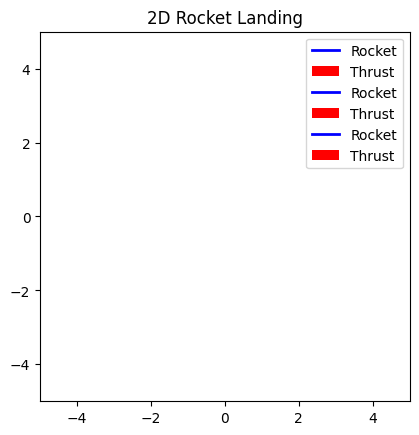

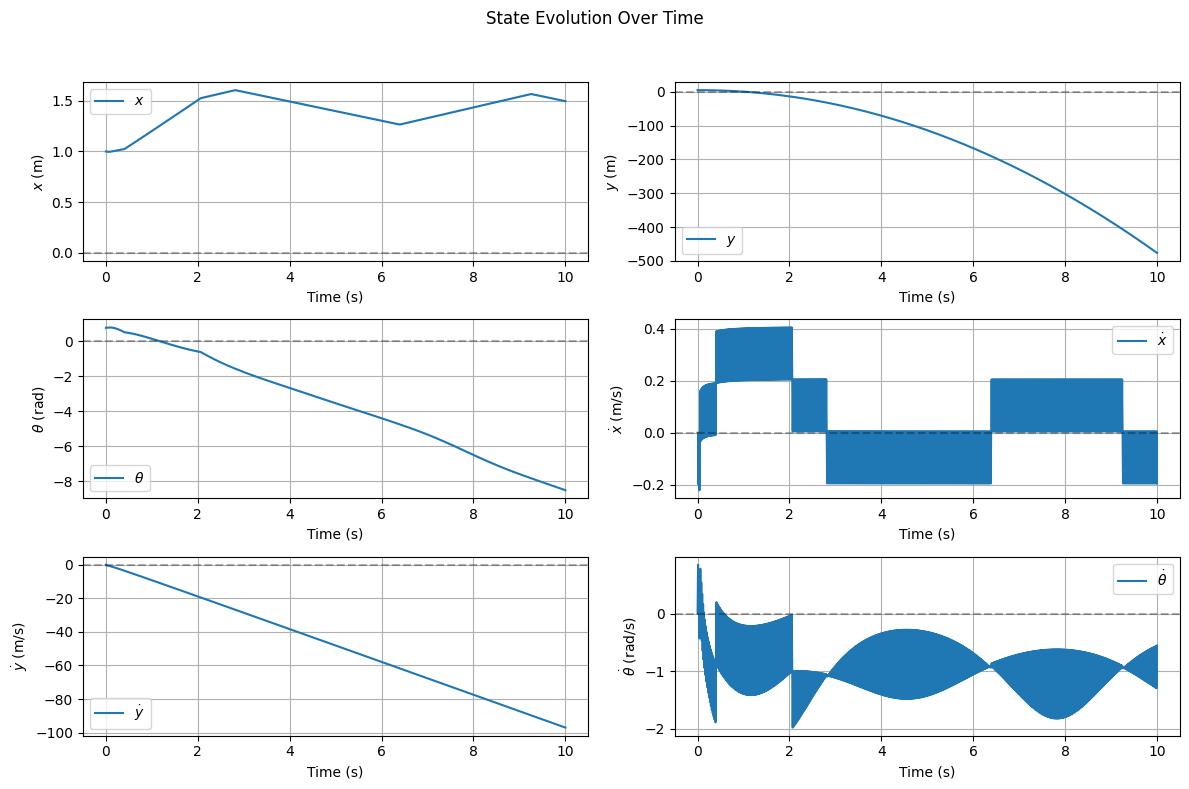

In [ ]:

# Demo
initial_state = [1.0, 5.0, np.pi/4, 0.0, 0.0, 0.0]  # [x, y, theta, x_dot, y_dot, theta_dot]
rocket = RocketPlant(initial_state, m=1.0, l=1.0)
controller = EnergyController(rocket, T_max=20.0, k=0.8)
sim = Simulation(rocket, controller, t_final=10.0)
sim.run()
animator = Animator(sim)
animation = animator.animate()

# Display animation in Jupyter/Colab
display(animation)

# Plot state evolution
plot_states(sim)